# Clustering Fatigue


In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats

from src.data.preprocessing import (
    load_and_preprocess_data,
    fix_numerical_features_for_production,
    remove_low_value_features,
)
from src.config.constants import NUMERICAL_FEATURES, RANDOM_SEED
from src.config.paths import (
    CLUSTERING_DIR,
    DNN_DIR,
    ensure_output_dirs,
    VALIDATION_COMBINED_DIR,
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import pandas as pd

In [2]:
ensure_output_dirs()
plt.rcParams["font.family"] = ["Roboto", "Arial", "sans-serif"]

## Pipeline Configuration & Data Loading

In [3]:
random_seed = RANDOM_SEED  # Random seed to ensure reproducibility
output_path = CLUSTERING_DIR

# We save the medians to a file so that we can use them
# in the production pipeline to fill missing values on new data
medians_path = DNN_DIR / "exports" / "medians.json"
df = load_and_preprocess_data(save_medians=True, medians_path=medians_path)

Median values saved to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/dnn/exports/medians.json


## Optimise Features for Production

In [4]:
# We removed low value features here and simplified the model
df = remove_low_value_features(df)
df = df.drop(columns=["study_id"])
numerical_features = NUMERICAL_FEATURES
numerical_features = fix_numerical_features_for_production(numerical_features)

In [5]:
X = df.drop(columns=["fatigue_outcome"])
y = df["fatigue_outcome"]

## Scale Numerical Features

In [6]:
unified_scaler = StandardScaler()
unified_scaler.fit(X[numerical_features])
X[numerical_features] = unified_scaler.transform(X[numerical_features])

## Deciding on value of k

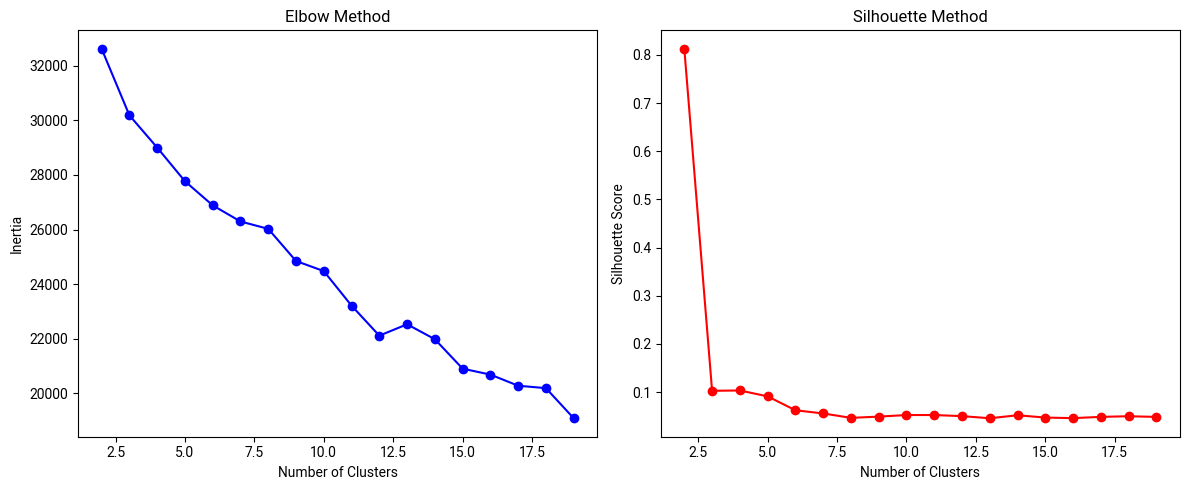

In [7]:
inertia = []
silhouette_scores = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, "ro-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.tight_layout()
plt.savefig(output_path / "optimal_clusters.png", dpi=300)
plt.show()

## Initial K-Means Clustering

In [8]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

In [9]:
n_clusters = 5  #  Initial trial and error
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
cluster_labels = kmeans.fit_predict(X)

# Create a DataFrame with features and cluster labels
cluster_df = X.copy()
cluster_df["cluster"] = cluster_labels

# Add fatigue outcome back to the DataFrame
cluster_df["fatigue_outcome"] = y.values

# Calculate cluster centroids
cluster_means = cluster_df.drop(columns=["fatigue_outcome"]).groupby("cluster").mean()
# Calculate the size of each cluster
cluster_sizes = cluster_df["cluster"].value_counts().sort_index()
print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    fatigue_percentage = (
        cluster_df[cluster_df["cluster"] == i]["fatigue_outcome"].mean() * 100
    )
    print(f"Cluster {i}: {size} patients ({fatigue_percentage:.1f}% with fatigue)")


def get_top_features(df, cluster_id, n_features=10):
    cluster_means = df.drop(columns=["fatigue_outcome"]).groupby("cluster").mean()
    # Calculate how much each feature in the cluster deviates from the global mean
    global_mean = df.mean()
    cluster_centroid = cluster_means.iloc[cluster_id]
    feature_deviations = abs(cluster_centroid - global_mean)
    top_features = feature_deviations.nlargest(n_features)

    top_features_dict = {}
    for feature in top_features.index:
        if feature in ["cluster", "fatigue_outcome"]:
            continue
        # Get the actual value for this feature in the cluster
        value = cluster_centroid[feature]
        top_features_dict[feature] = value

    return top_features_dict


Cluster sizes:
Cluster 0: 146 patients (80.1% with fatigue)
Cluster 1: 291 patients (51.5% with fatigue)
Cluster 2: 561 patients (40.8% with fatigue)
Cluster 3: 1 patients (100.0% with fatigue)
Cluster 4: 216 patients (48.1% with fatigue)


### Outlier Found From K>=4

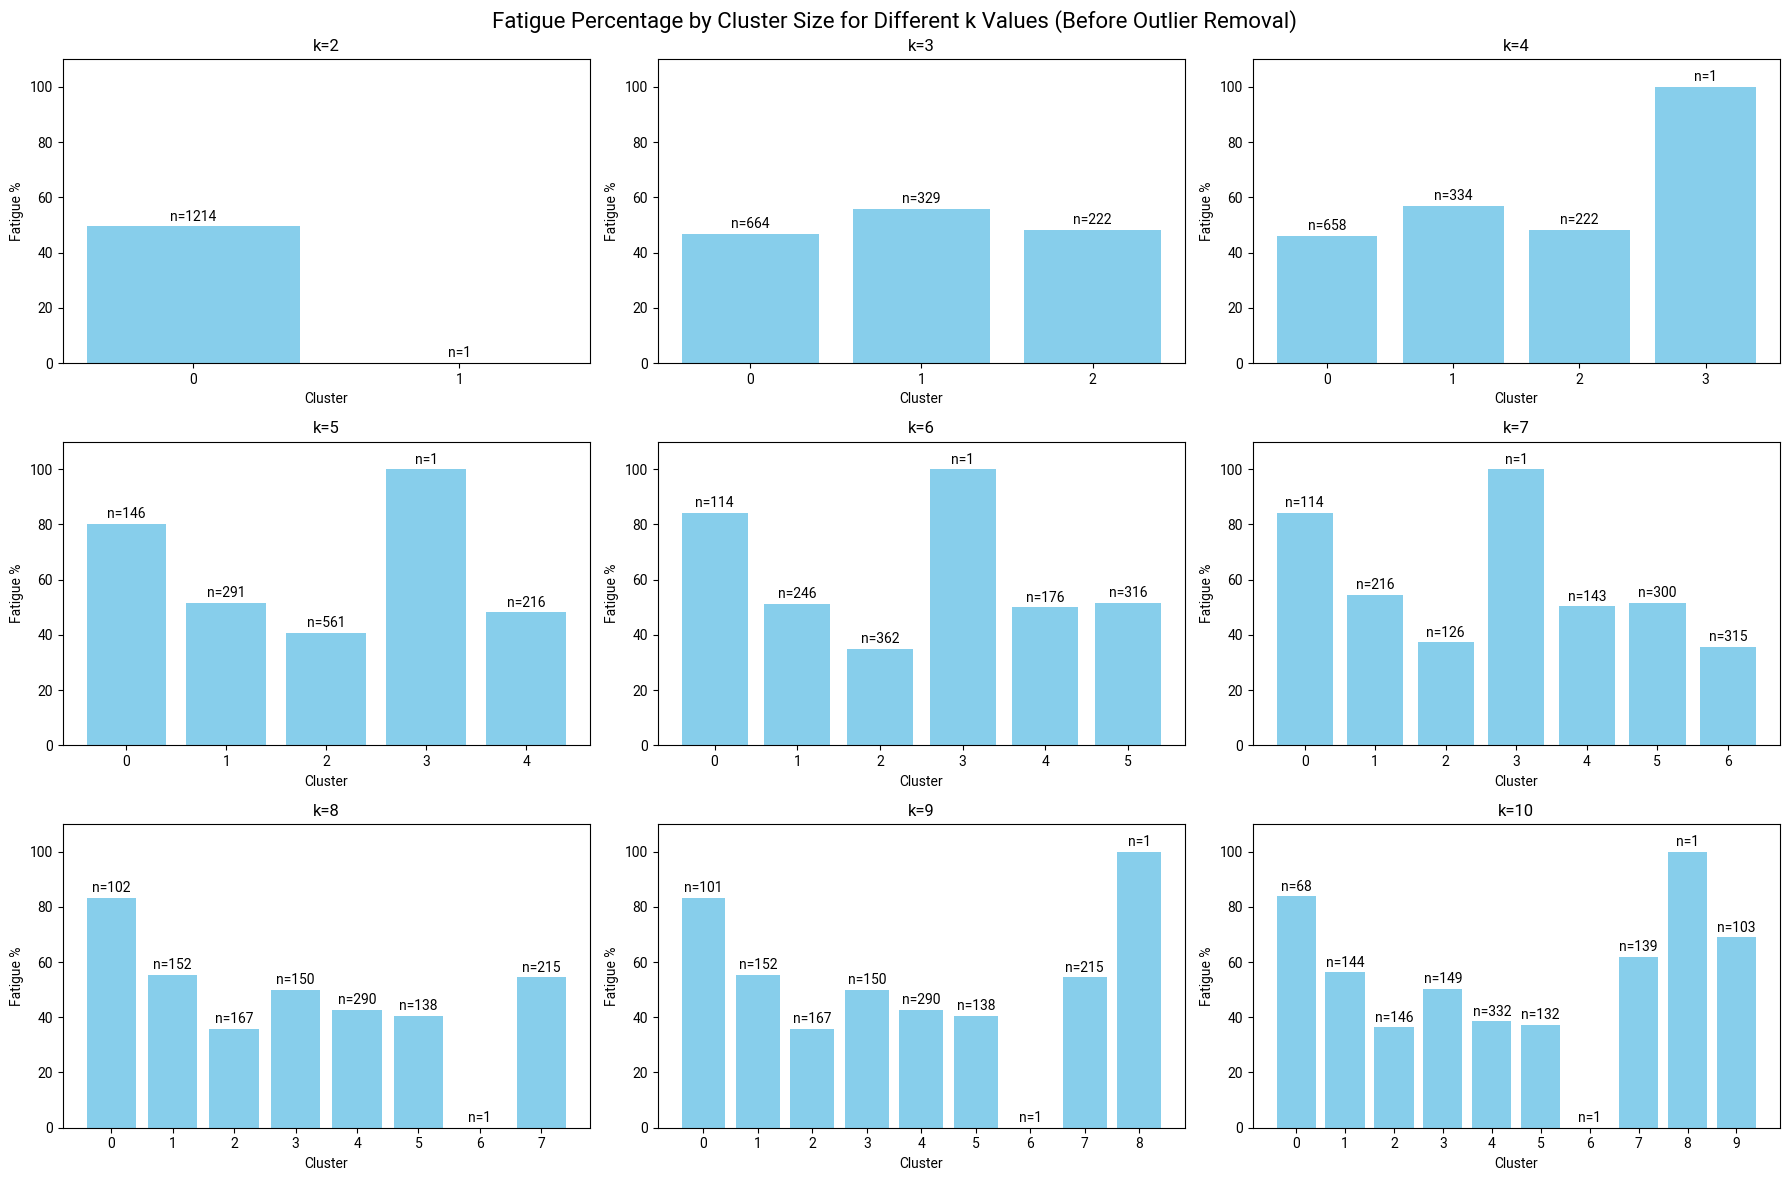

In [10]:
k_range = range(2, 11)
results = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    labels = kmeans.fit_predict(X)
    temp_df = X.copy()
    temp_df["cluster"] = labels
    temp_df["fatigue_outcome"] = y.values
    for cluster_id in range(k):
        cluster_size = (temp_df["cluster"] == cluster_id).sum()
        fatigue_pct = (
            temp_df[temp_df["cluster"] == cluster_id]["fatigue_outcome"].mean() * 100
        )
        results.append(
            {
                "k": k,
                "cluster": cluster_id,
                "size": cluster_size,
                "fatigue_pct": fatigue_pct,
            }
        )

results_df = pd.DataFrame(results)
# Plot: For each k, show fatigue % (y-axis) and annotate with cluster size (n)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, k in enumerate(k_range):
    ax = axes[idx]
    subset = results_df[results_df["k"] == k]
    bars = ax.bar(subset["cluster"], subset["fatigue_pct"], color="skyblue")
    ax.set_title(f"k={k}")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Fatigue %")
    ax.set_ylim(0, 110)
    # Annotate with number of patients
    for bar, size in zip(bars, subset["size"]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"n={int(size)}",
            ha="center",
            va="bottom",
            fontsize=10,
        )
    ax.set_xticks(subset["cluster"])

plt.suptitle(
    "Fatigue Percentage by Cluster Size for Different k Values (Before Outlier Removal)",
    fontsize=16,
)
plt.tight_layout()
plt.savefig(output_path / "k_values_on_original_df.png", dpi=300, bbox_inches="tight")
plt.show()

## Remove Outlier

In [11]:
# First, find the cluster with only 1 observation
outlier_cluster = cluster_sizes[cluster_sizes == 1].index[0]
print(f"Removing outlier cluster: {outlier_cluster}")

# Remove the outlier observation from X and y
outlier_indices = cluster_df[cluster_df["cluster"] == outlier_cluster].index
print(f"Outlier indices: {outlier_indices.tolist()}")

X_filtered = X.drop(index=outlier_indices)
y_filtered = y.drop(index=outlier_indices)

Removing outlier cluster: 3
Outlier indices: [1194]


### Reattempt Elbow and Silhouette Method

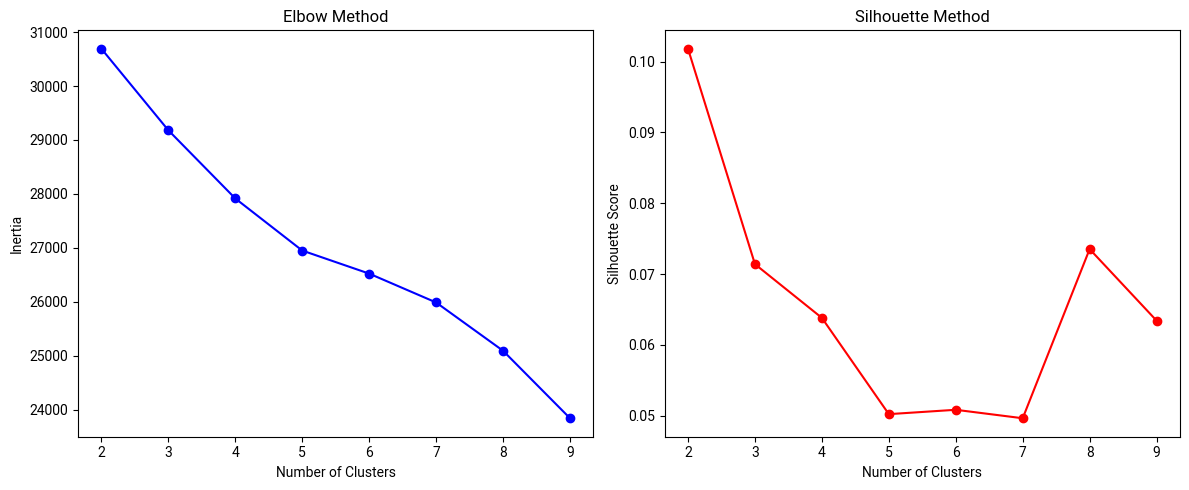

In [12]:
# Elbow method and silhouette method to find optimal number of clusters
# for KMeans clustering
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(X_filtered)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_filtered, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, "ro-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.tight_layout()
plt.savefig(output_path / "optimal_clusters_after_outlier_removal.png", dpi=300)
plt.show()

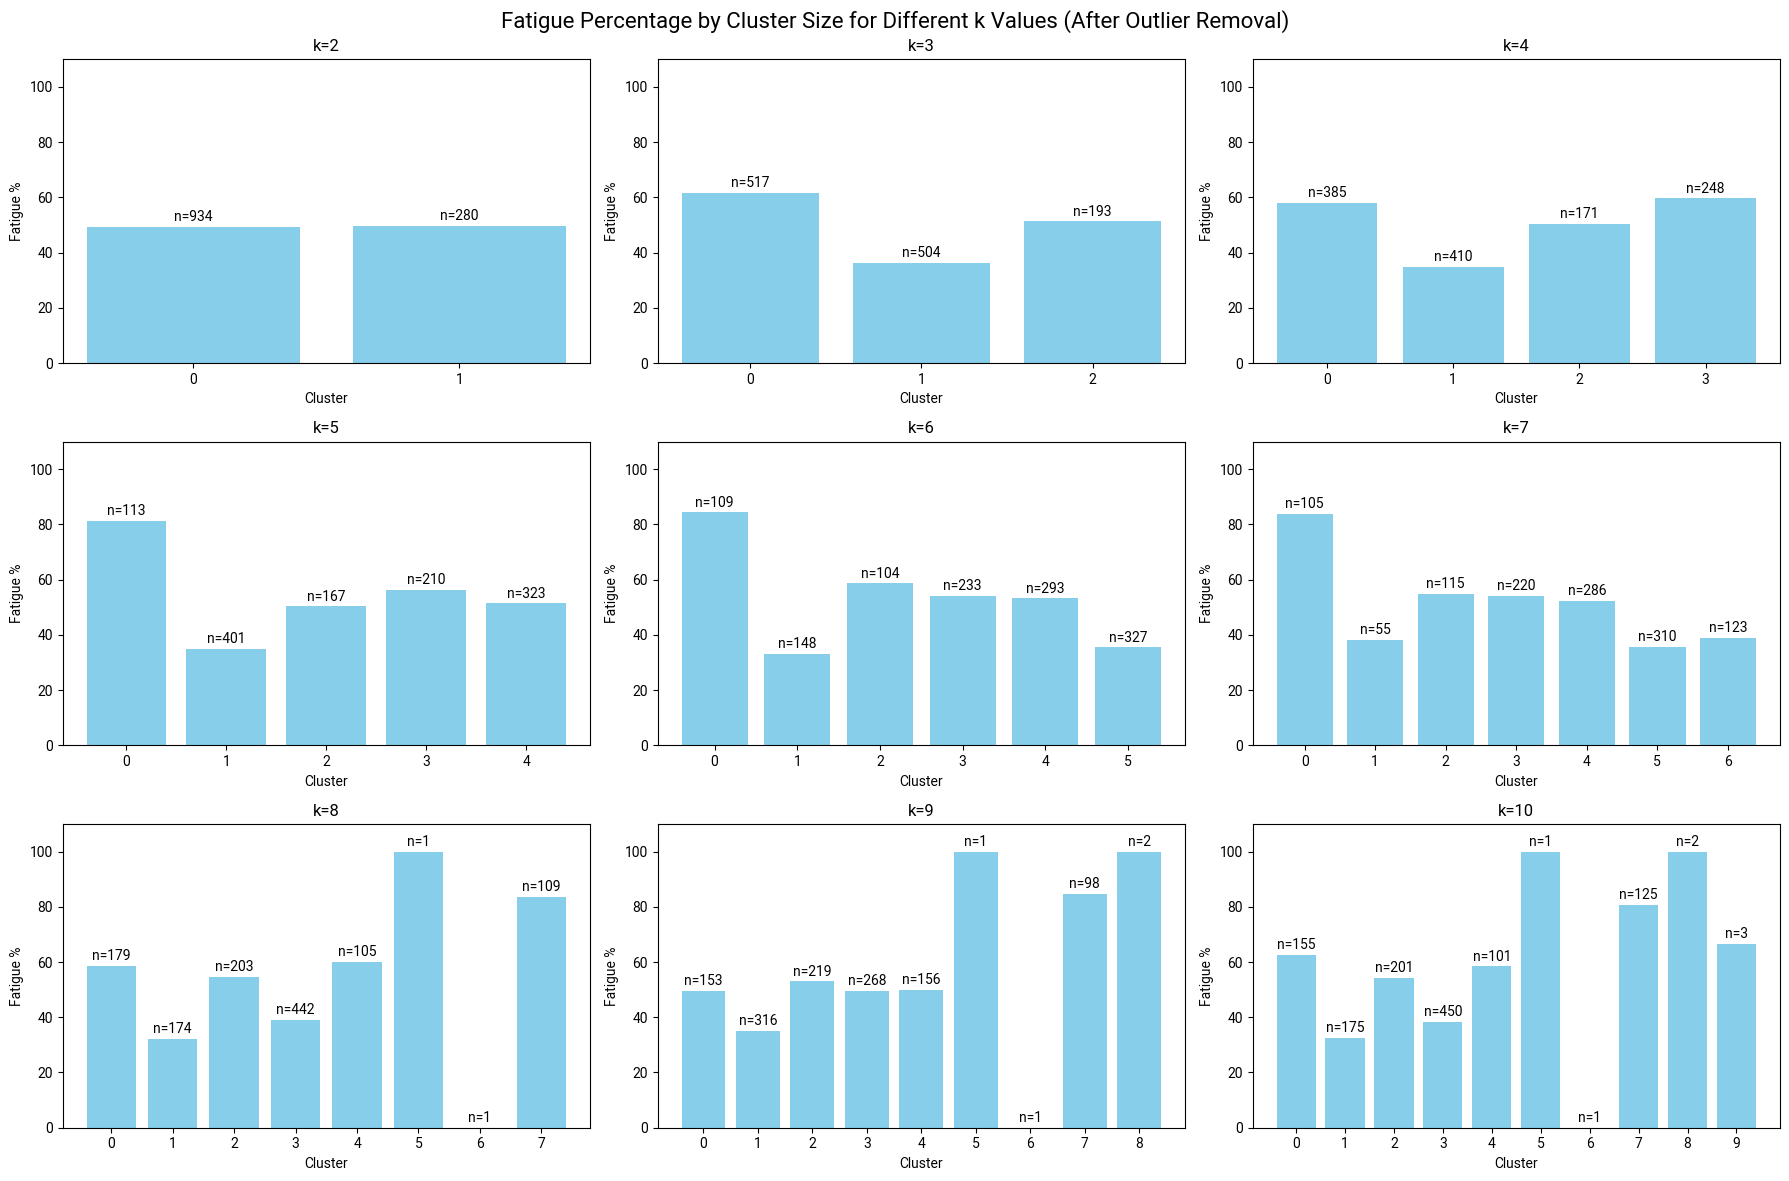

In [13]:
k_range = range(2, 11)
results = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    labels = kmeans.fit_predict(X_filtered)
    temp_df = X_filtered.copy()
    temp_df["cluster"] = labels
    temp_df["fatigue_outcome"] = y_filtered.values
    for cluster_id in range(k):
        cluster_size = (temp_df["cluster"] == cluster_id).sum()
        fatigue_pct = (
            temp_df[temp_df["cluster"] == cluster_id]["fatigue_outcome"].mean() * 100
        )
        results.append(
            {
                "k": k,
                "cluster": cluster_id,
                "size": cluster_size,
                "fatigue_pct": fatigue_pct,
            }
        )

results_df = pd.DataFrame(results)
# Plot: For each k, show fatigue % (y-axis) and annotate with cluster size (n)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, k in enumerate(k_range):
    ax = axes[idx]
    subset = results_df[results_df["k"] == k]
    bars = ax.bar(subset["cluster"], subset["fatigue_pct"], color="skyblue")
    ax.set_title(f"k={k}")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Fatigue %")
    ax.set_ylim(0, 110)  # Set y-axis limits to 0-100%
    # Annotate with number of patients
    for bar, size in zip(bars, subset["size"]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"n={int(size)}",
            ha="center",
            va="bottom",
            fontsize=10,
        )
    ax.set_xticks(subset["cluster"])

plt.suptitle(
    "Fatigue Percentage by Cluster Size for Different k Values (After Outlier Removal)",
    fontsize=16,
)
plt.tight_layout()
plt.savefig(
    output_path / "k_values_with_outlier_removed.png", dpi=300, bbox_inches="tight"
)
plt.show()

## K Decision and Final Clustering

Empirically testing the value of k shows that there is a clear outlier initially.

We remove it and reclustered the data. k=5 to k=7 look reasonable. k=4 does not separate out the active IBD patients.

On visual inspection, the better and simpler fit is k=5 as it subsets out a group of patients with clearly active IBD that we know clinically exists.

In [14]:
n_clusters_final = 5
kmeans = KMeans(n_clusters=n_clusters_final, random_state=RANDOM_SEED)
cluster_labels = kmeans.fit_predict(X_filtered)

final_cluster_df = X_filtered.copy()
final_cluster_df["cluster"] = cluster_labels
final_cluster_df["fatigue_outcome"] = y_filtered.values

final_cluster_means = (
    final_cluster_df.drop(columns=["fatigue_outcome"]).groupby("cluster").mean()
)
final_cluster_sizes = final_cluster_df["cluster"].value_counts().sort_index()

print("Final cluster sizes:")
for i, size in enumerate(final_cluster_sizes):
    fatigue_percentage = (
        final_cluster_df[final_cluster_df["cluster"] == i]["fatigue_outcome"].mean()
        * 100
    )
    print(f"Cluster {i}: {size} patients ({fatigue_percentage:.1f}% with fatigue)")

print("\nTop distinguishing features per cluster:")
for i in range(n_clusters):
    top_features = get_top_features(final_cluster_df, i)
    print(f"\nCluster: {i}")
    for feature, value in top_features.items():
        # Check if the feature is a numerical feature that was standardized
        if feature in numerical_features:
            # Convert back to original scale
            feature_idx = X_filtered.columns.get_loc(feature)
            numerical_idx = numerical_features.index(feature)
            original_mean = unified_scaler.mean_[numerical_idx]
            original_std = unified_scaler.scale_[numerical_idx]
            original_value = value * original_std + original_mean
            print(f"  {feature}: {original_value:.2f} (standardized: {value:.2f})")
        else:
            # For binary features
            print(f"  {feature}: {value:.2f}")

Final cluster sizes:
Cluster 0: 113 patients (81.4% with fatigue)
Cluster 1: 401 patients (34.9% with fatigue)
Cluster 2: 167 patients (50.3% with fatigue)
Cluster 3: 210 patients (56.2% with fatigue)
Cluster 4: 323 patients (51.4% with fatigue)

Top distinguishing features per cluster:

Cluster: 0
  platelets: 499.57 (standardized: 1.59)
  crp: 39.42 (standardized: 1.38)
  neutrophils: 12.25 (standardized: 1.33)
  haemoglobin: 116.07 (standardized: -1.14)
  white_cell_count: 16.12 (standardized: 0.83)
  calprotectin: 755.60 (standardized: 0.75)
  albumin: 29.61 (standardized: -0.61)
  sampling_steroids: 0.78
  eosinophils: 0.08 (standardized: -0.47)
  potassium: 7.42 (standardized: 0.46)

Cluster: 1
  height: 180.94 (standardized: 0.78)
  haemoglobin: 144.16 (standardized: 0.61)
  creatinine: 83.53 (standardized: 0.49)
  weight: 87.69 (standardized: 0.44)
  sex: 0.96
  platelets: 291.41 (standardized: -0.36)
  age: 34.98 (standardized: -0.35)
  disease_duration_weeks: 325.13 (standard

In [15]:
final_cluster_df_unscaled = final_cluster_df.copy()
final_cluster_df_unscaled[numerical_features] = unified_scaler.inverse_transform(
    final_cluster_df_unscaled[numerical_features]
)

<Figure size 3200x800 with 0 Axes>

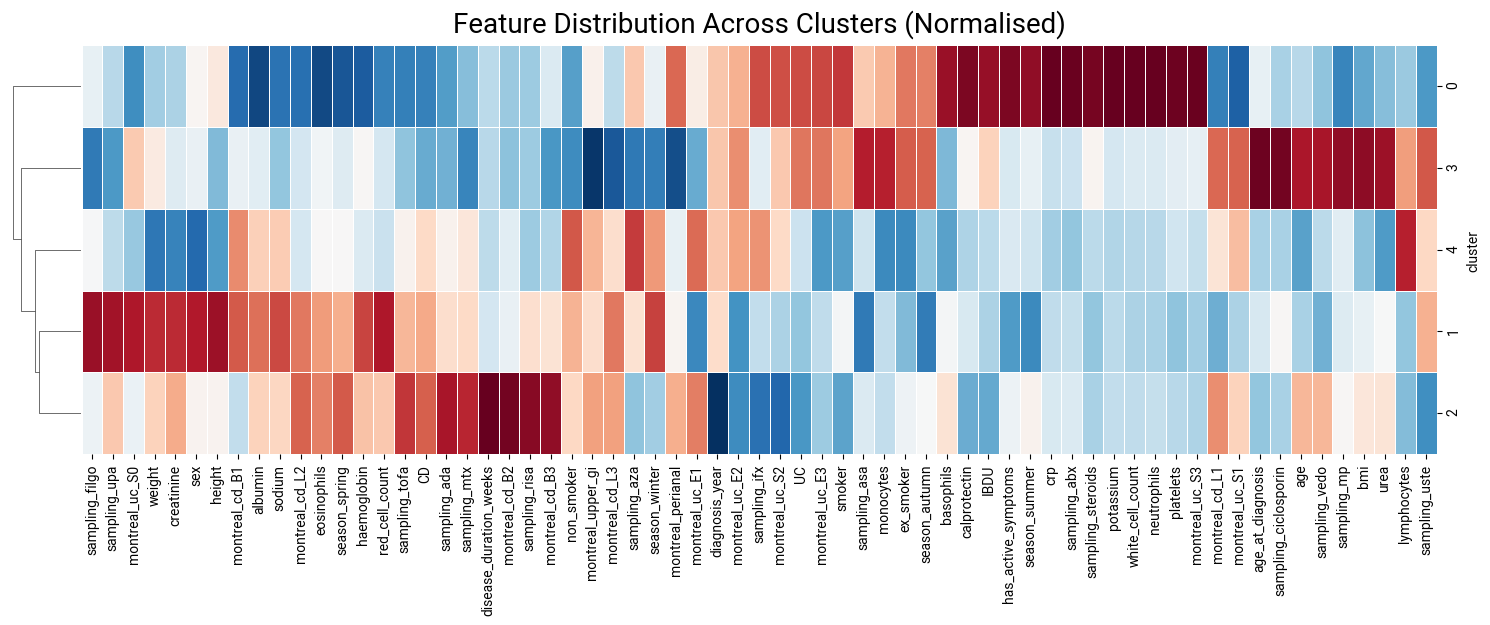

In [16]:
# Plot a heatmap of feature importance by cluster
plt.figure(figsize=(32, 8))
normalized_means = (
    final_cluster_means - final_cluster_means.mean()
) / final_cluster_means.std()
col_rename_dict = {
    "is_smoker_Ex-smoker": "ex_smoker",
    "is_smoker_Non-smoker": "non_smoker",
    "is_smoker_Smoker": "smoker",
    "study_group_name_CD": "CD",
    "study_group_name_IBDU": "IBDU",
    "study_group_name_UC": "UC",
    "montreal_cd_location_L1 Ileal": "montreal_cd_L1",
    "montreal_cd_location_L2 Colonic": "montreal_cd_L2",
    "montreal_cd_location_L3 Ileocolonic": "montreal_cd_L3",
    "montreal_cd_behaviour_B1 Non-stricturing, non-penetrating": "montreal_cd_B1",
    "montreal_cd_behaviour_B2 Stricturing": "montreal_cd_B2",
    "montreal_cd_behaviour_B3 Penetrating": "montreal_cd_B3",
    "montreal_uc_extent_E1 Proctitis": "montreal_uc_E1",
    "montreal_uc_extent_E2 Left-sided": "montreal_uc_E2",
    "montreal_uc_extent_E3 Extensive": "montreal_uc_E3",
    "montreal_uc_severity_S0 Remission": "montreal_uc_S0",
    "montreal_uc_severity_S1 Mild": "montreal_uc_S1",
    "montreal_uc_severity_S2 Moderate": "montreal_uc_S2",
    "montreal_uc_severity_S3 Severe": "montreal_uc_S3",
}
normalized_means.rename(columns=col_rename_dict, inplace=True)

g = sns.clustermap(
    normalized_means,
    cmap="RdBu_r",  # Strong diverging colormap
    center=0,
    annot=False,
    fmt=".2f",
    linewidths=0.5,  # Add grid lines for clarity
    cbar_kws={"shrink": 0.8, "label": "Z-score (by feature)"},
    xticklabels=True,
    cbar_pos=None,
    dendrogram_ratio=(0.05, 0),
    figsize=(15, 6),
)
plt.title(
    "Feature Distribution Across Clusters (Normalised)",
    fontsize=20,
    loc="center",
    pad=10,
)
plt.savefig(
    output_path / "final_cluster_feature_heatmap.png", dpi=300, bbox_inches="tight"
)
plt.show()

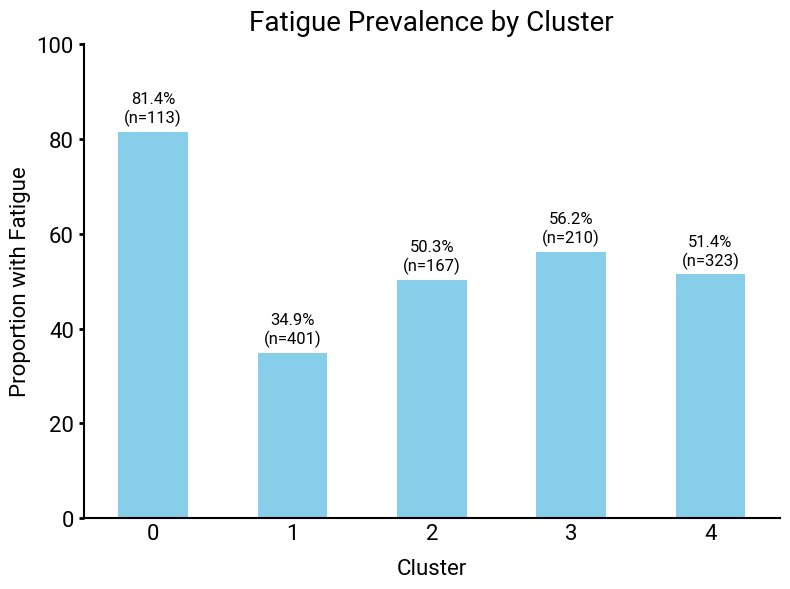

In [17]:
plt.figure(figsize=(8, 6))
# Calculate fatigue prevalence and cluster sizes
fatigue_by_cluster = final_cluster_df.groupby("cluster")["fatigue_outcome"].mean()
cluster_sizes = final_cluster_df["cluster"].value_counts().sort_index()

# Plot clusters in their natural (index) order, not sorted by fatigue
ax = fatigue_by_cluster.plot(kind="bar", color="skyblue", rot=0)
plt.title("Fatigue Prevalence by Cluster", fontsize=20, loc="center", pad=10)
plt.xlabel("Cluster", fontsize=16, labelpad=10)
plt.ylabel("Proportion with Fatigue", fontsize=16)
plt.ylim(0, 1)  # Set y-axis limits to 0-1

# Remove gridlines
plt.grid(False)

# Add percentage labels and cluster sizes above each bar
for i, (v, size) in enumerate(zip(fatigue_by_cluster, cluster_sizes)):
    ax.text(i, v + 0.02, f"{v * 100:.1f}%\n(n={size})", ha="center", fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=16, width=2)
# Remove x-axis ticklines
ax.tick_params(axis="x", length=0)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
# Set y-axis ticks to show 0 to 100%
ax.set_yticks([i / 5 for i in range(0, 6)])
ax.set_yticklabels([f"{int(i*20)}" for i in range(0, 6)])
plt.tight_layout()
plt.savefig(
    output_path / "fatigue_prevalence_by_final_clustering.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


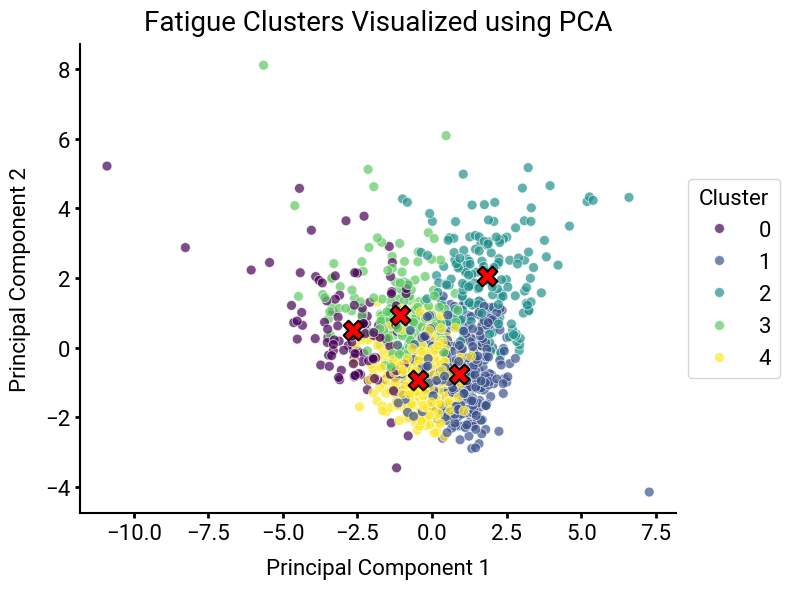

In [18]:
# Add this cell after the final clustering (after cell id: b7b5602b or after unscaled DataFrame creation)

from sklearn.decomposition import PCA

# Perform PCA on the filtered, standardized features
pca_final = PCA(n_components=2, random_state=RANDOM_SEED)
X_filtered_pca = pca_final.fit_transform(X_filtered)

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x=X_filtered_pca[:, 0],
    y=X_filtered_pca[:, 1],
    hue=final_cluster_df["cluster"],
    palette="viridis",
    s=50,
    alpha=0.7,
)
plt.title("Fatigue Clusters Visualized using PCA", fontsize=20, loc="center", pad=10)
plt.xlabel("Principal Component 1", fontsize=16, labelpad=10)
plt.ylabel("Principal Component 2", fontsize=16, labelpad=10)
plt.legend(title="Cluster", title_fontsize=16, fontsize=16, loc="center left",
    bbox_to_anchor=(1, 0.5) )

# Add cluster centroids in PCA space
centroids_final = kmeans.cluster_centers_
centroids_final_pca = pca_final.transform(centroids_final)
plt.scatter(
    centroids_final_pca[:, 0],
    centroids_final_pca[:, 1],
    s=200,
    marker="X",
    c="red",
    edgecolor="black",
    linewidth=1.5,
    #label="Centroids",
)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.tick_params(axis="both", which="major", labelsize=16, width=2)

plt.tight_layout()
plt.savefig(
    output_path / "final_patient_clusters_pca.png", dpi=300, bbox_inches="tight"
)
plt.show()

### ANOVA

ANOVA F-statistic: 22.596767100843895
ANOVA p-value: 5.078348644282417e-18
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -0.465    0.0 -0.6056 -0.3244   True
     0      2  -0.3112    0.0  -0.472 -0.1504   True
     0      3  -0.2523 0.0001 -0.4063 -0.0982   True
     0      4  -0.3002    0.0 -0.4445 -0.1559   True
     1      2   0.1539 0.0051  0.0323  0.2755   True
     1      3   0.2128    0.0  0.1003  0.3252   True
     1      4   0.1648 0.0001  0.0661  0.2635   True
     2      3   0.0589 0.7653  -0.078  0.1958  False
     2      4   0.0109 0.9993 -0.1149  0.1368  False
     3      4   -0.048 0.7961  -0.165  0.0691  False
----------------------------------------------------


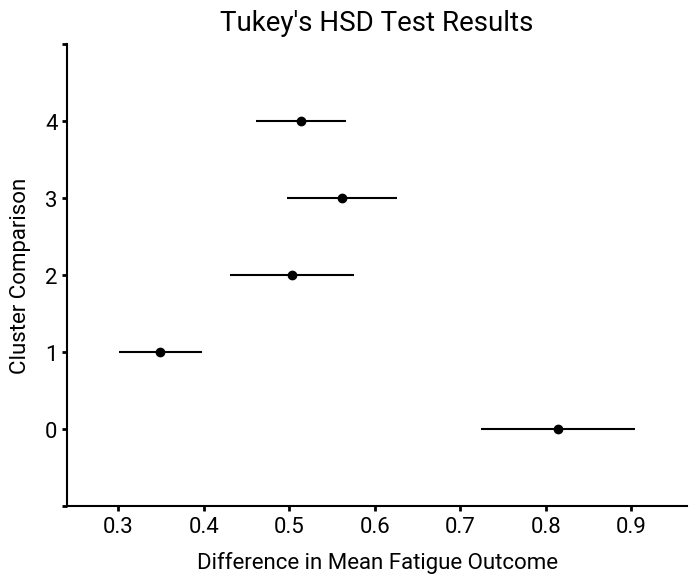

In [19]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data for ANOVA
groups = [
    final_cluster_df[final_cluster_df["cluster"] == c]["fatigue_outcome"]
    for c in final_cluster_df["cluster"].unique()
]

# One-way ANOVA
anova_result = f_oneway(*groups)
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Post hoc test (Tukey's HSD)
tukey = pairwise_tukeyhsd(
    endog=final_cluster_df["fatigue_outcome"],
    groups=final_cluster_df["cluster"],
    alpha=0.05,
)
print(tukey)
fig = tukey.plot_simultaneous(figsize=(8,6))
ax = fig.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=16, width=2)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.set_xlabel("Difference in Mean Fatigue Outcome", fontsize=16, labelpad=10)
ax.set_ylabel("Cluster Comparison", fontsize=16, labelpad=10)
ax.set_title("Tukey's HSD Test Results", fontsize=20, loc="center", pad=10)
plt.savefig(output_path / "tukey_hsd.png", dpi=300, bbox_inches="tight")
plt.show()

## Simplifying Analysis

We find that cluster 0 is high fatigue and cluster 1 is low fatigue. Clusters 2,3,4 are intermediate fatigue and not significantly different from each other. We therefore simplify the analysis by combining these clusters into a single group as primary analysis.

Secondary analysis will maintain the cluster separation.

In [20]:
# Add a column that collapses clusters 2,3,4 into cluster 2
final_cluster_df_unscaled["simplified_cluster"] = final_cluster_df_unscaled[
    "cluster"
].replace({0: 0, 1: 1, 2: 2, 3: 2, 4: 2})

In [21]:
# Save the final cluster DataFrame to a CSV file for further analysis in R for demographic comparisons
final_cluster_df_unscaled.to_csv(output_path / "final_clusters.csv", index=False)

## Clustering on Validation Set

In [22]:
X_combined = pd.read_csv(VALIDATION_COMBINED_DIR / "X_combined.csv")
y_combined = pd.read_csv(VALIDATION_COMBINED_DIR / "y_combined.csv")

In [23]:
combined_cluster_labels = kmeans.predict(X_combined)

validation_df = X_combined.copy()
validation_df["cluster"] = combined_cluster_labels
validation_df["fatigue_outcome"] = y_combined.values

External validation: Fatigue prevalence by cluster
Cluster 0: 7 patients (28.6% with fatigue)
Cluster 1: 65 patients (26.2% with fatigue)
Cluster 2: 49 patients (40.8% with fatigue)
Cluster 3: 56 patients (32.1% with fatigue)
Cluster 4: 75 patients (42.7% with fatigue)


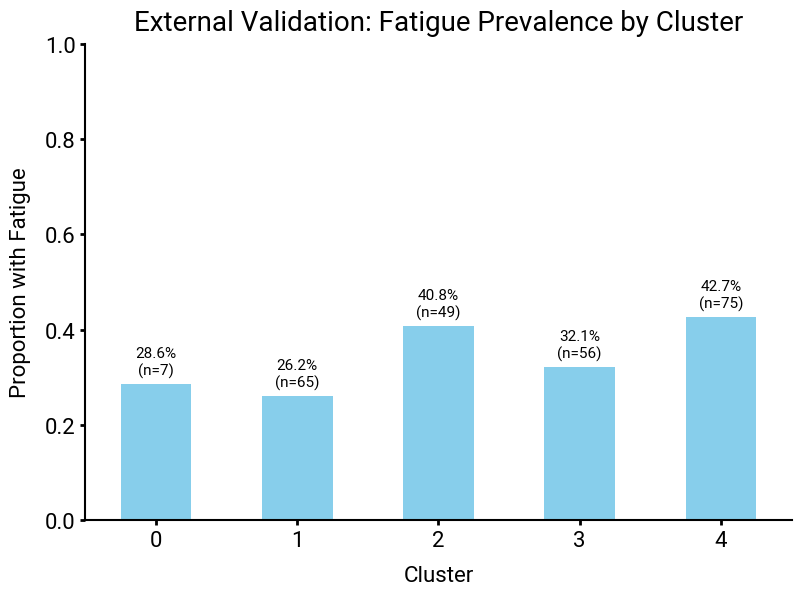

In [24]:
# 4. Analyze fatigue outcome by cluster
print("External validation: Fatigue prevalence by cluster")
for cluster_id in sorted(validation_df["cluster"].unique()):
    cluster_size = (validation_df["cluster"] == cluster_id).sum()
    fatigue_pct = (
        validation_df[validation_df["cluster"] == cluster_id]["fatigue_outcome"].mean()
        * 100
    )
    print(
        f"Cluster {cluster_id}: {cluster_size} patients ({fatigue_pct:.1f}% with fatigue)"
    )

# 5. Optional: Bar plot for visual comparison
plt.figure(figsize=(8, 6))
fatigue_by_cluster = validation_df.groupby("cluster")["fatigue_outcome"].mean()
cluster_sizes = validation_df["cluster"].value_counts().sort_index()
ax = fatigue_by_cluster.plot(kind="bar", color="skyblue", rot=0)
plt.title("External Validation: Fatigue Prevalence by Cluster", fontsize=20, loc="center", pad=10)
plt.xlabel("Cluster", fontsize=16, labelpad=10)
plt.ylabel("Proportion with Fatigue", fontsize=16, labelpad=10)
plt.ylim(0, 1)
for i, (v, size) in enumerate(zip(fatigue_by_cluster, cluster_sizes)):
    ax.text(i, v + 0.02, f"{v * 100:.1f}%\n(n={size})", ha="center", fontsize=11)
plt.tight_layout()

# Remove gridlines
plt.grid(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.tick_params(axis="both", which="major", labelsize=16, width=2)
plt.savefig(
    output_path / "external_validation_fatigue_prevalence_by_cluster.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

Seems reasonably aligned with initial clustering set. Does not contain enough examples in cluster 0 to be meaningful as we did most of the validation dataset in the outpatient setting and I suspect that cluster 0 is more likely to be found in the inpatient setting. Cluster 1 looks well replicated as the low fatigue group.

In [25]:
# Print all rows in validation_df where cluster == 0
cluster_0_validation = validation_df[validation_df["cluster"] == 0]
cluster_0_validation[numerical_features] = unified_scaler.inverse_transform(
    cluster_0_validation[numerical_features]
)
cluster_0_validation.head(7)

/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_26914/2369066438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0_validation[numerical_features] = unified_scaler.inverse_transform(


,age,sex,height,weight,bmi,age_at_diagnosis,montreal_upper_gi,montreal_perianal,has_active_symptoms,albumin,...,montreal_uc_severity_S3 Severe,is_smoker_Ex-smoker,is_smoker_Non-smoker,is_smoker_Smoker,season_autumn,season_spring,season_summer,season_winter,cluster,fatigue_outcome
4,37.279866,0,159.977010,58.372741,22.185884,17.334009,0.0,0.0,1.0,41.929779,...,0,1,0,0,0,1,0,0,0,0
14,39.332580,1,172.225445,78.055424,26.489537,38.923061,0.0,0.0,1.0,39.706038,...,0,1,0,0,0,1,0,0,0,1
43,18.805437,1,172.225445,77.071290,26.099424,17.334009,0.0,0.0,1.0,44.894767,...,0,0,1,0,0,1,0,0,0,0
61,61.912437,0,162.018416,66.245814,25.064288,50.231611,0.0,0.0,0.0,12.428148,...,0,1,0,0,0,1,0,0,0,0
160,59.859723,0,168.142634,91.833302,33.670168,57.427962,0.0,0.0,1.0,36.741050,...,0,1,0,0,0,1,0,0,0,0
177,52.675223,0,162.018416,65.261680,24.624841,44.063311,0.0,0.0,0.0,35.258556,...,0,0,1,0,1,0,0,0,0,0
224,36.253508,1,171.204742,75.791915,25.833738,25.558410,0.0,0.0,1.0,32.812441,...,1,0,1,0,1,0,0,0,0,1
